<H1><center><font color='limegreen'>E-commerce Customer Churn Analysis</font>
<br>----------

By : Fathur Rizky Maulana

-------------------------

## **Contents**

0. Initial Setup
1. Business Problem Understanding
2. Data Understanding
3. Data Preprocessing
4. Modeling
5. Conclusion
6. Recommendation

----
----

### **`Initial Setup`**

In [2]:
# Import library eksplorasi dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Membuat grafik
import seaborn as sns #Membuat grafik
import missingno as msno #Cek missing value
import phik #Cek phik korelasi
from sklearn.experimental import enable_iterative_imputer #Melakukan imputasi
from sklearn.impute import IterativeImputer #Melakukan iterative imputasi

# Import library sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate #Membagi data train dan data test
from pycaret.classification import * #Men-setting parameter dasar menggunakan pycaret
from sklearn.base import BaseEstimator, TransformerMixin #Membuat estimator
from sklearn.preprocessing import FunctionTransformer #Meneruskan argumen objek fungsi dan mengembalikan hasil dari fungsi ini
from sklearn.compose import ColumnTransformer #Melakukan kolom transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, make_scorer, classification_report, average_precision_score, precision_score, recall_score, confusion_matrix

from catboost import CatBoostClassifier

# Import library uji statistics
from scipy.stats import ks_2samp # Uji KS untuk melihat distorsi sebelum dan sesudah handling outlier
from scipy import stats

# Import library modeling
import pycaret
from pycaret.internal.preprocess.transformers import TransformerWrapper
from pycaret.internal.preprocess.transformers import RemoveOutliers

# Setting max column
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 35)

import warnings
warnings.filterwarnings('ignore')


import matplotlib
min_val, max_val = 0, 0.8
n = 10
orig_cmap = plt.cm.summer
colors = orig_cmap(np.linspace(min_val, max_val, n))
custom_summer = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors)

### **`Business Problem Understanding`**

#### **Context**

Berdasarkan definisi dari [Cambridge Dictionary](https://dictionary.cambridge.org/dictionary/english/churn-rate), istilah *Churn* adalah persentase dari pelanggan yang berhenti membeli produk atau layanan dari perusahaan tertentu, dihitung untuk periode waktu tertentu.

Dalam konteks bisnis *e-commerce*, istilah "***Churn***" mengacu pada keadaan dimana pelanggan berhenti menjadi pelanggan atau tidak lagi membeli produk pada *e-commerce* tersebut selama periode waktu tertentu. ***Churn Rate*** adalah salah satu metrik penting pada bisnis *e-commerce* karena metrik tersebut dapat menunjukkan banyak hal seperti tingkat kepuasan pelanggan, keterlibatan, dan loyalitas pelanggan terhadap *e-commerce*. Tingkat *churn rate* yang tinggi dapat mengindikasikan bahwa pelanggan tidak puas dengan produk atau layanan yang ditawarkan, atau mereka menemukan alternatif yang lebih baik di tempat lain.

#### **Problem Statement**

Terdapat perusahaan *e-commerce* yang memiliki masalah pada bisnis yang dijalankan-nya, pada *e-commerce* tersebut terdapat beberapa pelanggan yang sudah tidak lagi menjadi pelanggan atau tidak lagi berbelanja di *e-commerce* tersebut (***`Churn`***). *e-commerce* tersebut saat ini memiliki ***churn rate*** yang cukup tinggi, yaitu sebesar **16,33%** dari total pelanggan [(perhitungan *churn rate*)](https://www.paddle.com/resources/calculate-churn-rate), dimana nilai ideal untuk ***churn rate*** saat ini hanya berkisar 5% sampai 7% per tahun [(Monique Danao,2023)](https://www.forbes.com/advisor/business/churn-rate/). Oleh karena itu, hal tersebut akan berdampak pada jumlah pendapatan yang diterima oleh *e-commerce* tersebut, karena *churn rate* yang tinggi akan diikuti dengan penurunan pendapatan perusahaan.

Di sisi lain, ketika perusahaan salah memprediksi pelanggan ***Churn*** atau **tidak *Churn***, hal tersebut akan memberikan masalah kepada perusahaan. Contohnya, jika perusahaan akan melakukan usaha marketing ke semua pelanggan, maka besaran biaya yang dikeluarkan akan menjadi tinggi. Studi menunjukkan bahwa biaya untuk mendapatkan pelanggan baru adalah 5 sampai 25 kali lebih tinggi daripada biaya untuk mempertahankan pelanggan lama ([Amy Gallo, 2014](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers)).Adapun jika perusahaan hanya memberikan usaha marketing ke sebagian pelanggan, maka perusahaan bisa kehilangan pelanggan yang sebenarnya berpotensi menjadi pelanggan yang **tidak *Churn*** (`Loyal`).

Sehingga pernyataan masalah pada kasus ini adalah bagaimana perusahaan dapat memprediksi pelanggan *churn*  agar promo, diskon, iklan dan usaha marketing lainnya dialokasikan secara lebih efisien sehingga perusahaan tidak perlu mengeluarkan biaya terlalu besar?

#### **Project Stakeholders:**

Pihak stakeholders yang terlibat dan yang akan menggunakan model dari analisis ini adalah:
* ***Sales & Marketing Team***: Tim ini akan bertanggung jawab dalam mengembangkan dan merencanakan usaha marketing serta mengimplementasikan kepada pelanggan secara tepat dalam upaya memaksimalkan pendapatan perusahaan.
* ***Operations Team***: Tim ini akan bertanggung jawab dalam mengkoordinasikan serta mengurus rincian operasi, mengevaluasi gambaran besar operasi, dan memastikan bahwa area bisnis berjalan semulus dan seefektif mungkin.
* ***Finance Team***: Tim ini akan bertanggung jawab dalam mengatur keuangan perusahaan yang diakibatkan oleh usaha marketing.

Ketiga peran diatas memiliki tujuan yang sama yaitu memaksimalkan pendapatan perusahaan dengan tepat

#### **Goals**

*Stakeholders* dapat mengetahui serta memprediksi karakteristik dari jenis pelanggan yang ***Churn*** dan yang **Tidak *Churn***, sehingga mereka dapat menerapkan usaha marketing dengan tepat sasaran. Hal ini dapat menurunkan biaya yang diakibatkan oleh usaha marketing tersebut (*biaya akuisisi pelanggan*) dan diharapkan juga dapat meningkatkan profit dengan mempertahankan pelanggan yang loyal.

#### **Analytic Approach**

Metode dalam melakukan analisis *customer churn* ini menggunakan **analisis prediktif**, kemudian membangun model **`klasifikasi`** yang akan membantu *stakeholders* untuk dapat memprediksi jenis pelanggan *Churn* (tidak loyal) dan Tidak *Churn* (loyal) berdasarkan data historis.

#### **Metric Evaluation**

Karena kita akan memfokuskan pelanggan yang ***churn*** (**`Tidak Loyal`**), maka target yang kita tetapkan adalah sebagai berikut:

**Target**:   
`0` : pelanggan tidak *churn* (`Loyal`) Negative
<br>
`1` : pelanggan *churn* (`Tidak Loyal`) Positive

**Metric Evaluation**:

|                       | ***Not Churn*-`Pred`** | ***Churn*-`Pred`** |
| --------------------- | ---------------------- | ------------------ |
| ***Not Churn*-`Act`** |           TN           |          FP        |
| ***Churn*-`Act`**     |           FN           |          TP        |

**`Type 1 Error`** : **False Positive**
<br>
`Interpretasi`: pelanggan yang kenyataannya not *churn* (**Loyal**), tapi terprediksi sebagai pelanggan *churn* (**Tidak loyal**) 
<br>
`Konsekuensi`: 
* Perusahaan akan mengeluarkan biaya akuisisi pelanggan ([CAC](https://www.paddle.com/resources/customer-acquisition-cost)) untuk pelanggan yang tidak tepat
* Mengeluarkan biaya akuisisi pelanggan ([Customer Acquisition Cost (CAC)](https://scalecrush.io/blog/average-customer-acquisition-cost-ecommerce#:~:text=The%20average%20CAC%20on%20the%20eCommerce%20scene%20is%20around%20%2445%20to%20%2450.&text=Remember%2C%20there%20is%20no%20hard,acquisition%20is%20a%20great%20decision.)) untuk pelanggan yang tidak *churn* => **`$50`** (*worst case*)

**`Type 2 Error`** : **False Negative**
<br>
`Interpretasi`: pelanggan yang kenyataannya *churn* (**Tidak Loyal**), tapi terprediksi sebagai pelanggan not *churn* (**loyal**)
<br>
`Konsekuensi`: 
* Perusahaan akan kehilangan potensi pelanggan yang bisa saja menjadi pelanggan yang loyal.
* Mengeluarkan biaya retensi pelanggan Customer Retention Cost ([CRC](https://finmark.com/glossary/customer-retention-cost/)) untuk pelanggan yang *churn* => **`$10`** (*5 kali lebih rendah dari (CAC) ([Amy Gallo, 2014](https://hbr.org/2014/10/the-value-of-keeping-the-right-customers))*)

Berdasarkan konsekuensi diatas, menurut langkah yang tepat untuk pemilihan model adalah model yang **sebanyak mungkin memprediksi `kelas positif yang benar` (*True Postive*)**, dan **sesedikit mungkin memprediksi `kelas positif yang salah` (*False Negative*)**. Jadi metrik utama yang akan digunakan adalah **PR-AUC** (*Precision-Recall Curve*). Matrik **PR-AUC** dipilih Dikarenakan kita lebih membutuhkan perhitungan `true positif` dibandingkan `true negatif` dan memiliki kelas yang `imbalance`, maka **PR-AUC** adalah metrik pengukuran yang tepat yakni kombinasi antara recall dan presisi berdasarkan treshold.


### **`Data Understanding`**

Dataset dan deskripsi dapat di akses pada link berikut:
<br>
[E-commerce Customer Churn](https://drive.google.com/drive/folders/1PITb78NtK9Ra6wOkQdXCIgItZkj29Ves)

| Columns                                            | Definition                                                   | 
| ------------------------------------------------- | ------------------------------------------------------------ |
| `Tenure` | Masa tenure pelanggan (`bulan`) |
| `WarehouseToHome` | Jarak antara warehouse ke rumah pelanggan (`mil`) |
| `NumberOfDeviceRegistered` | Jumlah perangkat yang terdaftar (`unit`) |
| `PreferedOrderCat` | Kategori yang disukai pelanggan bulan lalu |
| `SatisfactionScore` | Skor kepuasan pelanggan terhadap service |
| `MaritalStatus` | Status pernikahan pelanggan |
| `NumberOfAddress` | Jumlah alamat yang terdaftar |
| `Complain` | Adakah complain dalam satu bulan terakhir |
| `DaySinceLastOrder` | Hari sejak pemesanan terakhir (`hari`) |
| `CashbackAmount` | Rata-rata cashback bulan lalu (`$`) |
| `Churn` | Status churn pelanggan |

**`Complain`** == `0` : Tidak Ada *complain*, `1` : ada *complain*
<br>
**`Churn`** == `0` : Tidak *churn*, `1` : *Churn*

In [3]:
# Import file CSV

df = pd.read_csv("D:\Purwadhika JCDS\Capstone Project\Modul-3\data\\raw\data_ecommerce_customer_churn.csv")
print(f'Jumlah baris dan kolom: {df.shape}')

df.sample(10)

Jumlah baris dan kolom: (3941, 11)


,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
2121,16.0,9.0,4,Mobile Phone,3,Married,2,1,1.0,151.96,0
799,NaN,6.0,4,Mobile,3,Married,2,0,3.0,120.07,0
561,15.0,12.0,2,Mobile Phone,3,Divorced,4,1,4.0,146.27,0
2261,NaN,9.0,3,Mobile Phone,2,Divorced,2,0,0.0,117.06,0
3175,23.0,29.0,4,Grocery,4,Married,5,0,3.0,289.13,0
2562,9.0,7.0,4,Fashion,3,Single,3,0,NaN,212.89,0
1177,12.0,12.0,4,Fashion,5,Married,5,0,7.0,199.91,0
2145,15.0,14.0,3,Others,1,Married,2,0,9.0,284.30,0
3417,7.0,6.0,4,Mobile,4,Divorced,6,0,2.0,132.94,0
3750,7.0,32.0,5,Laptop & Accessory,4,Single,3,0,3.0,168.20,0


#### **Initial Assessment**

In [4]:
# Check karakteristik dataset

pd.DataFrame(
        {
        'feature': df.columns.values,
        'data_type': df.dtypes.values,
        'total_row': df.isna().count().values,
        'total_null': df.isna().sum().values,
        '%null_value': df.isna().mean().values * 100,
        'n_unique': df.nunique().values,
        'sample_unique': [df[col].unique() for col in df.columns]
        }
    )

,feature,data_type,total_row,total_null,%null_value,n_unique,sample_unique
0,Tenure,float64,3941,194,4.922608,36,"[15.0, 7.0, 27.0, 20.0, 30.0, 1.0, 11.0, 17.0,..."
1,WarehouseToHome,float64,3941,169,4.288252,33,"[29.0, 25.0, 13.0, 15.0, 16.0, 11.0, 12.0, 7.0..."
2,NumberOfDeviceRegistered,int64,3941,0,0.000000,6,"[4, 3, 6, 2, 5, 1]"
3,PreferedOrderCat,object,3941,0,0.000000,6,"[Laptop & Accessory, Mobile, Fashion, Others, ..."
4,SatisfactionScore,int64,3941,0,0.000000,5,"[3, 1, 4, 2, 5]"
5,MaritalStatus,object,3941,0,0.000000,3,"[Single, Married, Divorced]"
6,NumberOfAddress,int64,3941,0,0.000000,14,"[2, 5, 7, 8, 3, 1, 9, 4, 10, 11, 6, 19, 22, 21]"
7,Complain,int64,3941,0,0.000000,2,"[0, 1]"
8,DaySinceLastOrder,float64,3941,213,5.404720,22,"[7.0, nan, 8.0, 11.0, 2.0, 1.0, 4.0, 3.0, 6.0,..."
9,CashbackAmount,float64,3941,0,0.000000,2335,"[143.32, 129.29, 168.54, 230.27, 322.17, 152.8..."


__Insight :__
<br>

* Numerical Variable:
<br>
    - `Discrete` : NumberOfDeviceRegistered, NumberOfAddress
<br>
    - `Continue` : Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount
* Categorical variable:
<br>
    - `Nominal` : PreferedOrderCat, MaritalStatus, **Churn**
<br>
    - `Ordinal` : SatisfactionScore, Complain
* `Target`: Churn
* Terdapat total 3.941 jumlah baris pada dataset
* Tipe data untuk setiap variabel sudah sesuai
* Terdapat missing value pada kolom "*Tenure*" sebanyak 194 data (4.92%), "*WarehouseToHome*" sebanyak 169 data (4.29%), dan "*DaySinceLastOrder*" sebanyak 213 data (5.40%). (*analisis lebih lanjut*)
* Pada kolom "*CashbackAmount*" memiliki unique value yang sangat banyak sebesar 2335 unique value. Maka kita akan kelompokan berdasarkan kelasnya

Lalu kita akan coba melihat statistik deskriptif sederhana dari dataset ini

In [5]:
# Deskriptif statistik

display(
    # numerical variable
    df.describe(),
    # categorical variable
    df.describe(include='object')
)

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
count,3747.000000,3772.000000,3941.000000,3941.000000,3941.000000,3941.000000,3728.000000,3941.000000,3941.000000
mean,10.081398,15.650583,3.679269,3.088302,4.237757,0.282416,4.531652,176.707419,0.171023
std,8.498864,8.452301,1.013938,1.381832,2.626699,0.450232,3.667648,48.791784,0.376576
min,0.000000,5.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,3.000000,2.000000,2.000000,0.000000,2.000000,145.700000,0.000000
50%,9.000000,14.000000,4.000000,3.000000,3.000000,0.000000,3.000000,163.340000,0.000000
75%,16.000000,21.000000,4.000000,4.000000,6.000000,1.000000,7.000000,195.250000,0.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,1.000000,46.000000,324.990000,1.000000


,PreferedOrderCat,MaritalStatus
count,3941,3941
unique,6,3
top,Laptop & Accessory,Married
freq,1458,2055


__Insight :__
* Pesebaran nilai pada kolom ***CashbackAmount*** cukup besar, ditunjukan dari nilai standar deviasi 48.79

#### **Numerical variable**

##### **Numerikal Diskrit** (*NumberOfDeviceRegistered, NumberOfAddress*)

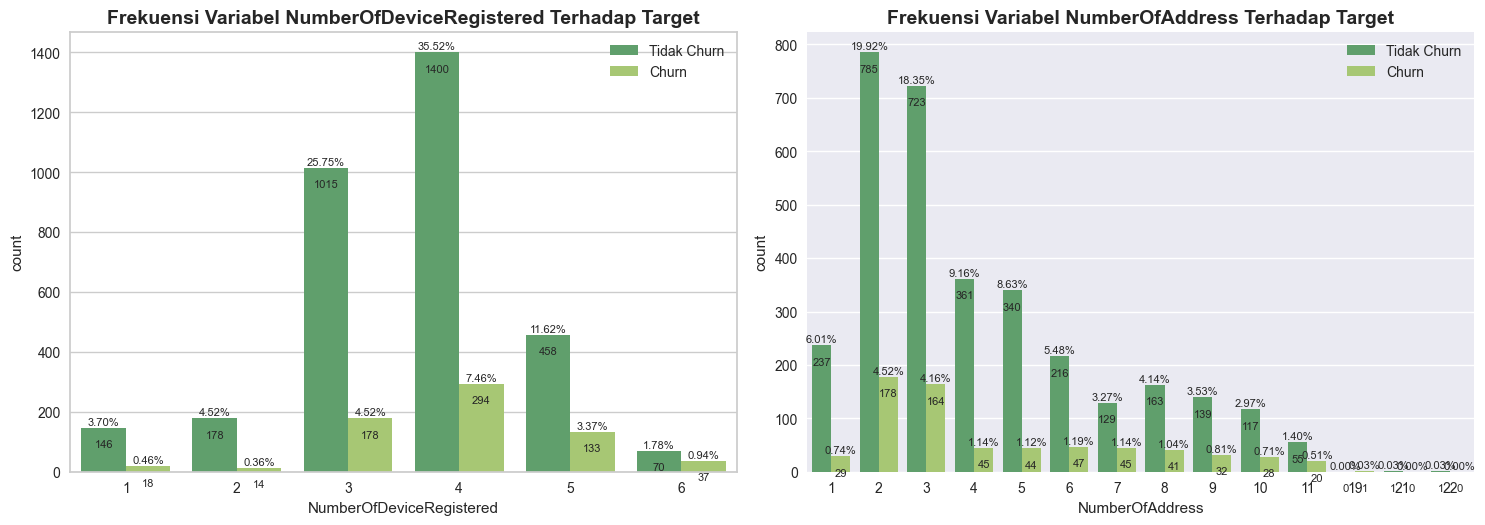

In [6]:
# Cek variabel numerikal diskrit

diskrit = ["NumberOfDeviceRegistered", "NumberOfAddress"]

plt.figure(figsize=(15,10))
cmap = plt.get_cmap("summer")

a=1
for i in diskrit:
    plt.subplot(2,2,a)
    ax = sns.countplot(data=df, x=i, hue="Churn", palette="summer")
    plt.legend(labels=["Tidak Churn", "Churn"])
    plt.tight_layout()
    plt.style.use("seaborn")
    plt.title(f"Frekuensi Variabel {i} Terhadap Target", fontsize=14, weight="bold")
    a+=1
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / len(df):.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center', size=8,)
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center',
                    size=8,
                    xytext = (0, -12), 
                    textcoords = 'offset points')

plt.show()

__Insight :__
* Pada kolom ***NumberOfDeviceRegistered***, pelanggan dengan jumlah device terdaftar lebih dari 2 device cenderung akan *churn* (*diatas 4% dari total pelanggan*). Hal ini mungkin karena pelanggan memiliki banyak opsi e-commerce dan pelanggan tersebut dapat berpindah-pindah e-commerce
* Pada kolom ***NumberOfAddress***, pelanggan yang memiliki jumlah address 2 dan 3 akan cenderung churn (*diatas 4% dari total pelanggan*). Untuk jumlah address lebih dari 11, kemungkinan merupakan nilai outlier, maka perlu dianalisis kembali

##### **Numerikal Kontinyu** (*Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount*)

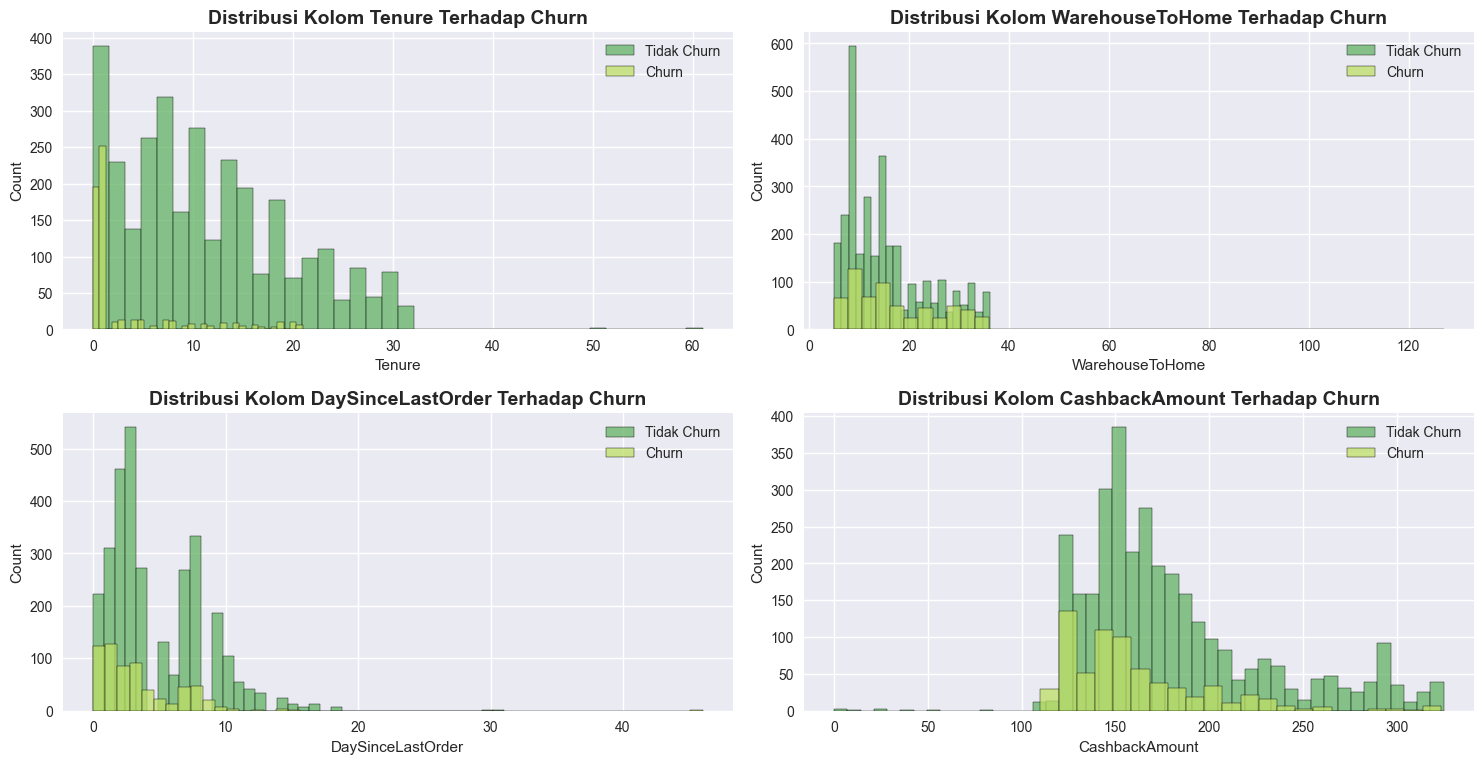

In [7]:
# Cek variabel numerikal kontinyu

kontinu = ["Tenure", "WarehouseToHome", "DaySinceLastOrder", "CashbackAmount"]

plt.figure(figsize=(15,15))
cmap = plt.get_cmap("summer")

a=1
for i in kontinu:
    plt.subplot(4,2,a)
    sns.histplot(x=df[df["Churn"]==0][i],color=cmap([100]))
    sns.histplot(x=df[df["Churn"]==1][i],color=cmap([190]))
    plt.legend(labels=["Tidak Churn", "Churn"])
    plt.tight_layout()
    plt.title(f"Distribusi Kolom {i} Terhadap Churn", fontsize=14, weight='bold')
    a+=1

plt.show()

In [8]:
df.DaySinceLastOrder.describe()

count    3728.000000
mean        4.531652
std         3.667648
min         0.000000
25%         2.000000
50%         3.000000
75%         7.000000
max        46.000000
Name: DaySinceLastOrder, dtype: float64

__Insight :__
* Pada kolom ***Tenure***, pelanggan churn terjadi pada awal bulan pemakaian yaitu di bulan ke-0 hingga bulan ke-2. Hal tersebut kemungkinan bisa terjadi dikarenakan pelanggan masih beradaptasi dengan platform e-commerce dan merasa tidak cocok dengan platform tersebut
* Pada kolom ***WarehouseToHome***, pelanggan dengan jarak gudang ke rumah kurang dari 20 mil cenderung churn. Hal tersebut mungkin dikarenakan ongkos kirim yang terlalu mahal untuk jarak yang dekat dengan rumah
* Pada kolom ***DaySinceLastOrder***, pelanggan terbanyak churn terjadi satu sampai dua hari setelah melakukan order. Hal tersebut mungkin terjadi dikarenakan pelanggan hanya membutuhkan barang dari e-commerce dan tidak tertarik dengan platform e-commerce tersebut
* Pada kolom ***CashbackAmount*** (nilai dibawah 100 dolar kemungkinan adalah nilai outlier), semakin rendah cashback yang diberikan maka semakin banyak pelanggan yang churn
* Pada **semua kolom numerikal kontinyu** pesebaran data tidak merata, hal ini terjadi karena terdapat rare label. Maka perlu dilakukan analisa kembali

##### **Feature Selection** (Numerikal)

In [9]:
columns = ['NumberOfDeviceRegistered', 'NumberOfAddress', 'Tenure', 'WarehouseToHome', 'DaySinceLastOrder', 'CashbackAmount']
Churns = [0, 1]

for column in columns:
    for Churn in Churns:
        data = df[(df["Churn"]==Churn)][column].dropna()
        stat, p_val = stats.shapiro(data)

        print(f"Hasil uji Shapiro-Wilk untuk '{column}' ({Churn} Churn):")
        print(""if p_val > 0.05 else "Data tidak terdistribusi normal.")
        print()



Hasil uji Shapiro-Wilk untuk 'NumberOfDeviceRegistered' (0 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'NumberOfDeviceRegistered' (1 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'NumberOfAddress' (0 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'NumberOfAddress' (1 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'Tenure' (0 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'Tenure' (1 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'WarehouseToHome' (0 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'WarehouseToHome' (1 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'DaySinceLastOrder' (0 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'DaySinceLastOrder' (1 Churn):
Data tidak terdistribusi normal.

Hasil uji Shapiro-Wilk untuk 'CashbackAmount' (0 Churn):
Data tidak terdistr

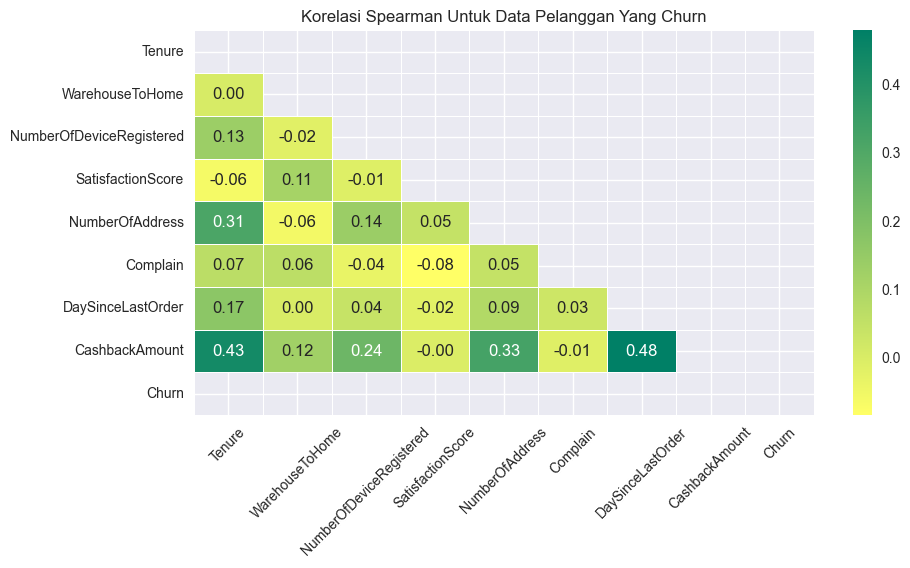

In [10]:
# Kolerasi Churn 1 (Churn)
mask = np.triu(np.ones_like(df[df['Churn'] == 0].corr(method='spearman'), dtype=bool))

plt.figure(figsize=(10, 5))
sns.heatmap(df[df['Churn'] == 1].corr(method='spearman'), annot=True, cmap='summer_r', fmt='.2f', linewidths=0.5, mask=mask)
plt.title("Korelasi Spearman Untuk Data Pelanggan Yang Churn")
plt.xticks(rotation = 45)
plt.show()

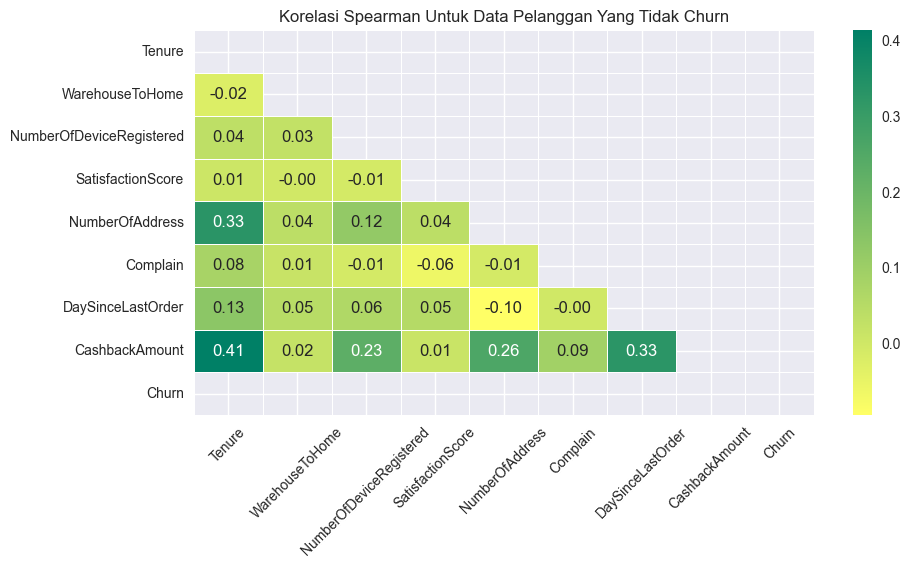

In [11]:
# Kolerasi Churn 0 (Tidak Churn)
mask = np.triu(np.ones_like(df[df['Churn'] == 0].corr(method='spearman'), dtype=bool))

plt.figure(figsize=(10, 5))
sns.heatmap(df[df['Churn'] == 0].corr(method='spearman'), annot=True, cmap='summer_r', fmt='.2f', linewidths=0.5, mask=mask)
plt.title("Korelasi Spearman Untuk Data Pelanggan Yang Tidak Churn")
plt.xticks(rotation = 45)
plt.show()

In [12]:
# df.drop("NumberOfAddress",axis=1,inplace=True)

#### **Categorical variable**

##### **Kategorikal Nominal** (*PreferedOrderCat, MaritalStatus, Churn*)

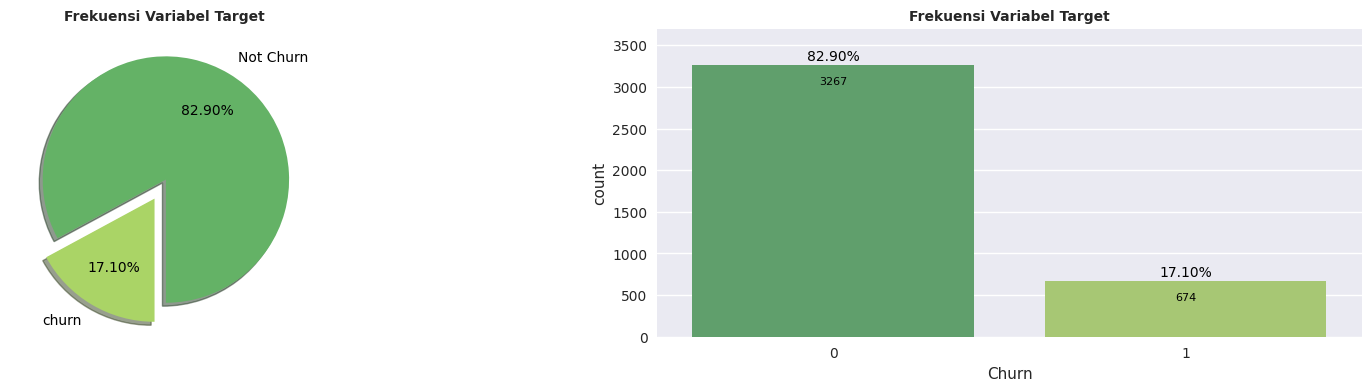

In [13]:
# Melihat kategori Churn

# Mengatur proporsi grafik
fig, axes = plt.subplots(1, 2, figsize=(20,4))
plt.style.use('default')
cmap = plt.get_cmap('summer')

# create pie chart
temp_df = df.Churn.value_counts(normalize=True) * 100
axes[0].pie(x=[temp_df.loc[0], temp_df.loc[1]], labels=['Not Churn', 'churn'], colors=cmap([100, 170]), autopct='%0.2f%%', 
        startangle=270, pctdistance=0.65, labeldistance=1.15, explode=(0.03, 0.15), shadow=True)
# set title
axes[0].set_title('Frekuensi Variabel Target', fontsize=10, weight='bold')

# create barplot
plt.title("Frekuensi Variabel Target", fontsize=10, weight='bold')
# set title dan 
ax = sns.countplot(data=df, x="Churn", palette="summer")
ax.set_ylim([0, 3700])
# annotation
for p in ax.patches:
        percentage = f'{100 * p.get_height() / len(df):.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')

for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center',
                    size=8,
                    xytext = (0, -12), 
                    textcoords = 'offset points')

plt.show();

__Insight :__
* Jumlah pengguna yang ***Churn*** (`Tidak Loyal`) sebanyak 674 (17.10%)
* Jumlah pengguna yang **Tidak *Churn*** (`Loyal`) sebanyak 3267 (82.90%)
* Dari dataset terjadi ***Imbalance***, maka kita akan lakukan analisis mendalam

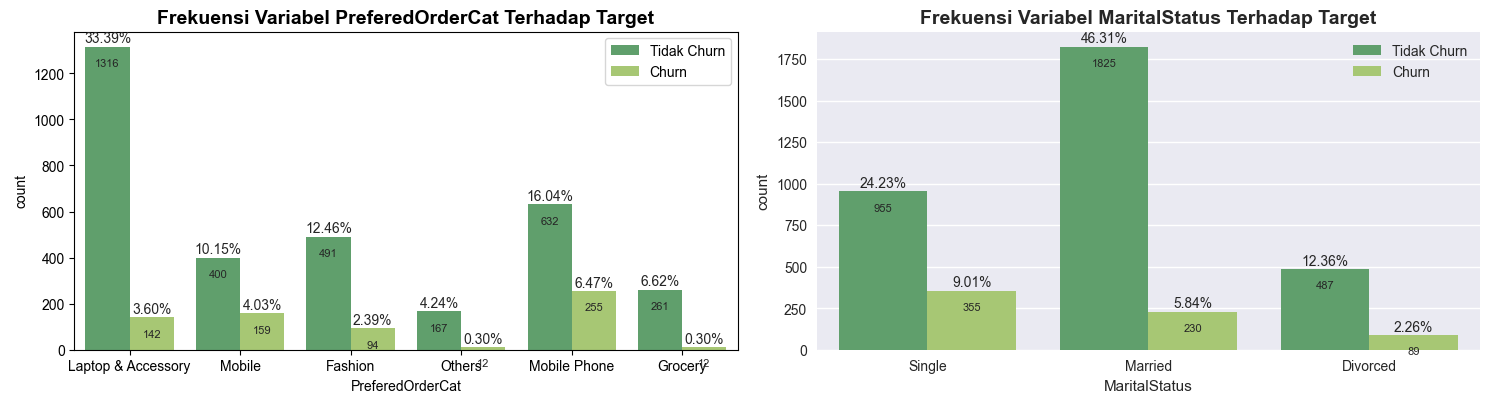

In [14]:
# Cek variabel kategorikal nominal

nominal = ["PreferedOrderCat", "MaritalStatus"]

plt.figure(figsize=(15,15))
cmap = plt.get_cmap("summer")

a=1
for i in nominal:
    plt.subplot(4,2,a)
    ax = sns.countplot(data=df, x=i, hue="Churn", palette="summer")
    plt.legend(labels=["Tidak Churn", "Churn"])
    plt.tight_layout()
    plt.style.use("seaborn")
    plt.title(f"Frekuensi Variabel {i} Terhadap Target", fontsize=14, weight="bold")
    a+=1
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / len(df):.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center',
                    size=8,
                    xytext = (0, -12), 
                    textcoords = 'offset points')

plt.show()

__Insight :__
* Kategori "*Mobile*" dan "*Mobile Phone*" bisa memiliki arti yang sama. Kita bisa mengganti kategori "***Mobile***" menjadi "***Mobile Phone***"
* *E-commerce* tersebut didominasi olah pelanggan yang membeli barang elektronik (*Laptop & Accesorry* serta *Mobile Phone*). Hal ini menandakan bahwa kategori tersebut adalah kategori barang favorit
* Kategori "*Mobile Phone*" memiliki jumlah pelanggan *churn* tertinggi sebesar 414 (10.50%) (*setelah kategori "***Mobile***" dan "***Mobile Phone***" digabungkan*) dari total pelanggan. Hal ini berarti pelanggan yang membeli *Mobile Phone* hanya memiliki tujuan untuk membeli barang tersebut saja, dan tidak tertarik untuk membeli kembali di e-commerce
* Pada kolom ***PreferedOrderCat*** karena merupakan feature bertipe kategorikal dan memiliki jumlah kategori yang cukup banyak (5 kategori ***setelah Kategori "*Mobile*" dimasukan ke kategori "*Mobile Phone*"**). Maka kita akan menerapkan ***`Binnary Encoding`*** pada preprocessing data
* Pengguna *e-commerce* terbanyak pada variabel *Marital Status* adalah kategori ***Married*** sebesar 2055 (52.15%)
* Pengguna *e-commerce* dengan *churn* terbanyak adalah ***Single*** sebesar 355 (9.01%) dari total pelanggan
* Pada kolom ***MaritalStatus*** karena merupakan feature bertipe kategorikal dan memiliki jumlah kategori yang cukup sedikit (3 kategori) dan tidak memiliki urutan. Maka kita akan menerapkan ***`One Hot Encoding`*** untuk ***MaritalStatus*** pada preprocessing data

Mengganti kategori ***Mobile*** menjadi kategori ***Mobile Phone***

In [15]:
# Mengganti kategori Mobile menjadi kategori Mobile Phone

df.replace("Mobile", "Mobile Phone", inplace=True)

##### **Kategorikal Ordinal** (*SatisfactionScore, Complain*)

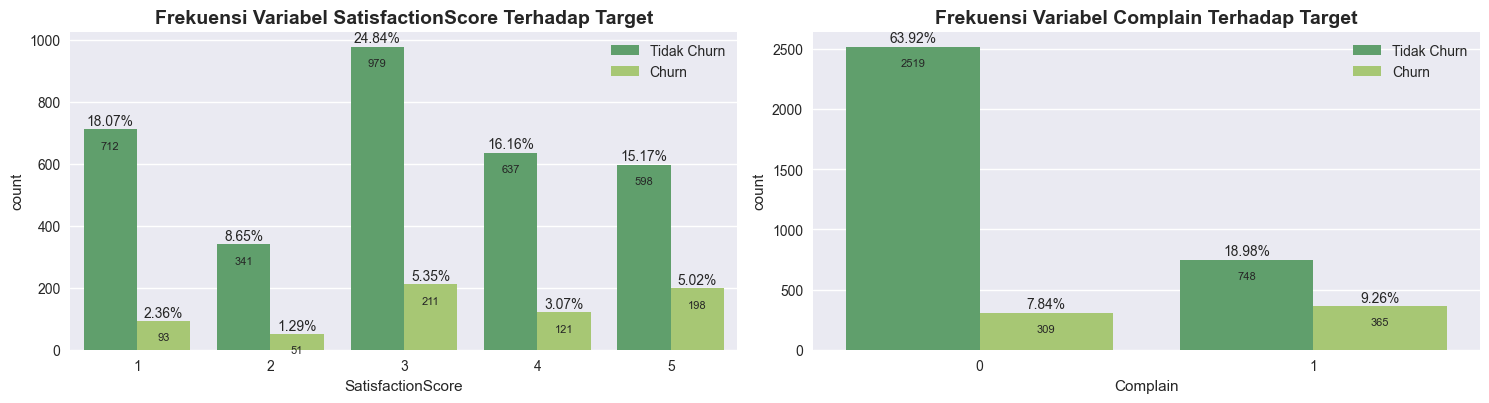

In [16]:
# Cek variabel kategorikal ordinal

ordinal = ["SatisfactionScore", "Complain"]

plt.figure(figsize=(15,15))
cmap = plt.get_cmap("summer")

a=1
for i in ordinal:
    plt.subplot(4,2,a)
    ax = sns.countplot(data=df, x=i, hue="Churn", palette="summer")
    plt.legend(labels=["Tidak Churn", "Churn"])
    plt.tight_layout()
    plt.style.use("seaborn")
    plt.title(f"Frekuensi Variabel {i} Terhadap Target", fontsize=14, weight="bold")
    a+=1
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / len(df):.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center',
                    size=8,
                    xytext = (0, -12), 
                    textcoords = 'offset points')
        
plt.show()

__Insight :__
* Pada kolom ***SatisfactionScore***, pelanggan yang memilih SatisfactionScore diatas 2 cenderung churn
* Pada kolom ***Complain***, pelanggan yang churn lebih banyak melakukan complain. Hal ini harus menjadi perhatian untuk e-commerce dalam upaya peningkatan kualitas layanan nya 

##### **Feature Selection** (Kategorikal)

Kita akan melakukan melihat korelasi antar fitur. Tujuan mengidentifikasi kolerasi antar fitur kategorikal ini untuk mencari fitur kategorikal yang mempunyai korelasi antar fitur kategorikal lainnya. Dimana kedua fitur mempunyai tingkat kolerasi tinggi maka bisa dipilih salah satu

interval columns not set, guessing: ['SatisfactionScore', 'Complain']


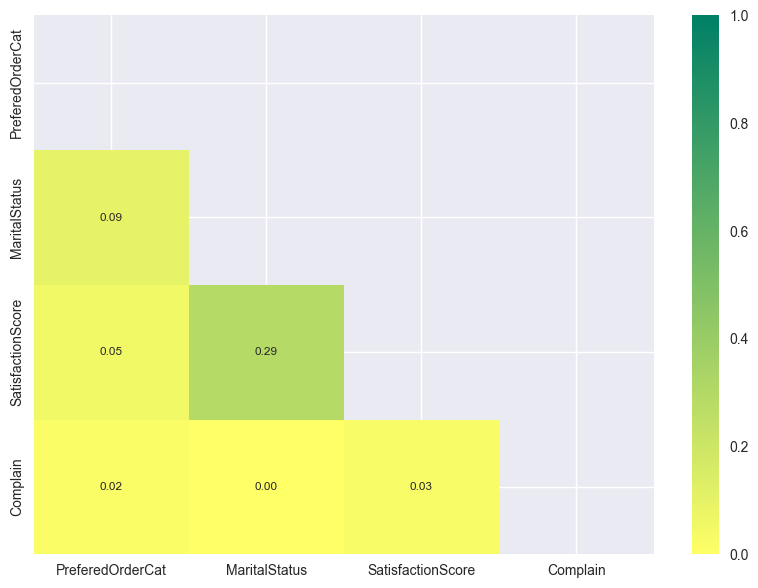

In [17]:
dfCorrMap = df[['PreferedOrderCat', 'MaritalStatus', 'SatisfactionScore', 'Complain']]
# heatmap of variable correlation 
fig, ax = plt.subplots(figsize=(10, 7))
phik_overview = dfCorrMap.phik_matrix()
corr_mask = np.triu(np.ones_like(phik_overview, dtype=bool))
sns.heatmap(phik_overview ,mask=corr_mask, vmin=0, vmax=1, annot=True, cmap="summer_r", fmt='.2f', annot_kws={"fontsize":8.5})

plt.show()

In [18]:
# df.drop("Complain",axis=1,inplace=True)

### **`Data Preprocessing`**

In [19]:
# find the lower bound and upper bound variable

def CheckBound(x):
    Q1 = int(x.quantile([0.25]).values)
    Q3 = int(x.quantile([0.75]).values)
    IQR = Q3-Q1
    LowerBound = Q1-1.5*IQR
    UpperBound = Q3+1.5*IQR
    total = len(df[(x<LowerBound) | (x>UpperBound)])

    result = f'''
        Lower Bound is: {LowerBound}
        Upper Bound is: {UpperBound}
        Total Outlier is: {total}'''
    
    return result

#### **Finding Problematic Data**

##### **> Missing Value**, Deteksi dan kuantifikasi missing value:

Text(0.5, 1.0, 'Cek Missing Value')

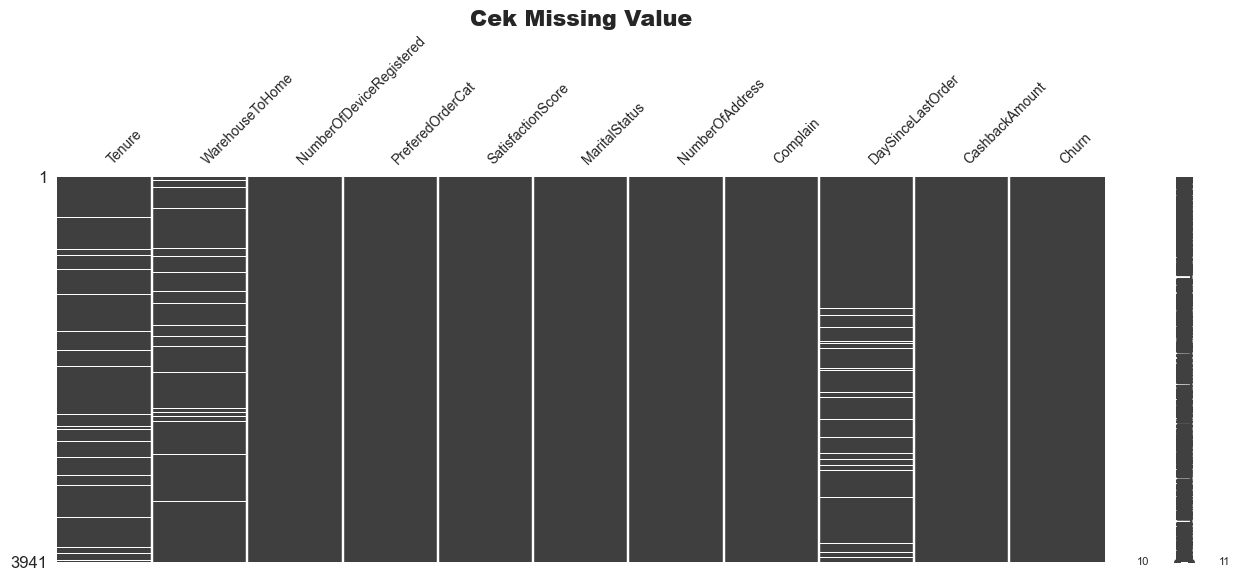

In [20]:
# Cek missing value

msno.matrix(df, figsize=(15,5), fontsize=10)
plt.title("Cek Missing Value", fontsize=16, weight="extra bold")

In [21]:
# Cek jumlah missing value masing-masing kolom

print(df.isna().sum())

# Kalkulasi missing value
print(f'''\nJumlah total missing value: {df.isnull().sum().sum()}
Jumlah baris yang terdapat missing value: {df[df.isnull().any(axis=1)].shape[0]}
Persentase baris dengan missing value: {round(df.isnull().sum().sum()/df.shape[0]*100,2)}%''')

Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64

Jumlah total missing value: 576
Jumlah baris yang terdapat missing value: 576
Persentase baris dengan missing value: 14.62%


__Insight :__
* Terdapat tiga kolom missing value "***Tenure***"(160), "***WarehouseToHome***"(135), "***DaySinceLastOrder***"(182) (float64)
* Jumlah total missing value adalah 476, dan lokasi missing value di baris yang berbeda-beda (476 baris), dengan presentase missing value 14.56% dari total data tersedia
* Kita tidak bisa lakukan drop missing value (karena jumlah missing value yang cukup besar 14.56%)
* Missing value tidak menunjukan pola tertentu/ acak (**MAR**)
* Perlu analisis lebih lanjut mengenai handling missing value

In [22]:
# # # Cek corelations matrix untuk kolom "Tenure", "WarehouseToHome", "DaySinceLastOrder"

# plt.style.use('default')

# fig, ax = plt.subplots(2, 1, figsize=(15, 10))
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.1)

# cols = df.columns
# corr = df[cols].phik_matrix()
# corr_mask = np.triu(np.ones_like(corr, dtype=bool))
# sns.heatmap(corr, mask=corr_mask, vmin=0, vmax=1, annot=True, cmap="YlGnBu", ax=ax[0])

# sig = df[cols].significance_matrix()
# sig_mask = np.triu(np.ones_like(sig, dtype=bool))
# sns.heatmap(sig, mask=sig_mask, annot=True, cmap="YlGnBu", ax=ax[1])

# ax[0].set_title(f"Correlation $\phi_K$")
# ax[1].set_title(f"Significance matrix")



__Insight :__
* Dari 3 kolom yang memiliki mising value ("***Tenure***", "***WarehouseToHome***", "***DaySinceLastOrder***"), tidak ada yang berkorelasi signifikan dengan feature lainnya
* Solution : Lakukan imputasi menggunakan metode **`Multivariate Imputation`**/ **`Iterative Imputer`** pada bagian preprocessing

##### **> Outlier,** Deteksi dan kuantifikasi outlier:

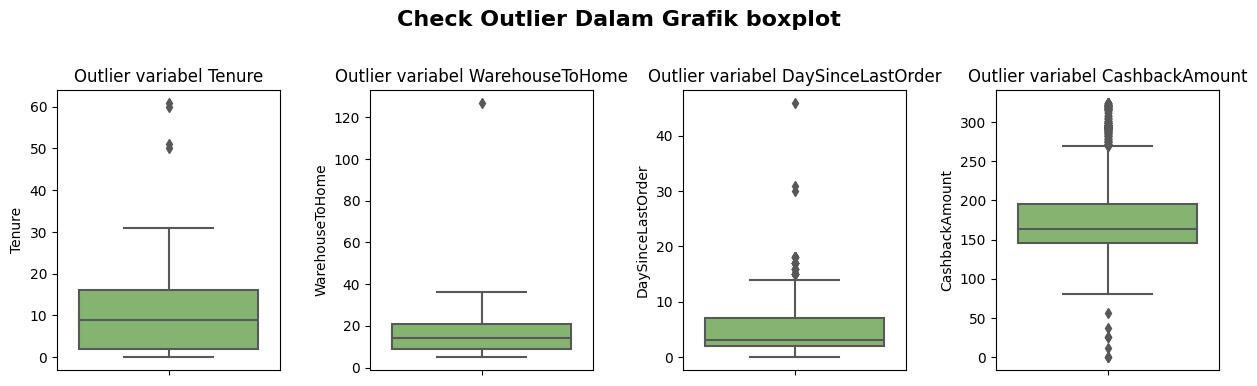

In [23]:
# Cek data outlier untuk continue variable (Tenure, WarehouseToHome, DaySinceLastOrder, CashbackAmount)

contVar = ["Tenure", "WarehouseToHome", "DaySinceLastOrder", "CashbackAmount"]

plt.style.use("default")
ax = plt.figure(figsize=(15, 8))
for i in range(0, len(contVar)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=df[contVar[i]], palette="summer")
    plt.title(f"Outlier variabel {contVar[i]}", fontsize=12, ha="center")

ax.suptitle("Check Outlier Dalam Grafik boxplot", fontsize=16, weight="extra bold")
ax.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4)
plt.show()

In [24]:
# Melihat lower bound, upper bound, outlier, dan persentase outlier

totalOutlier =0
for i in range(0, len(contVar)):
    Q1 = df[contVar[i]].quantile(0.25)
    Q3 = df[contVar[i]].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound =  Q1 - (1.5 * IQR)
    upper_bound =  Q3 + (1.5 * IQR)
    condition = (df[contVar[i]]< lower_bound) | (df[contVar[i]]> upper_bound)
    outlier = df.loc[condition, contVar[i]].count()
    totalOutlier+=outlier
    PersentaseOutlier = outlier/df[contVar[i]].count()*100
    print(f"{contVar[i]}\nLower Bound   : {round(lower_bound,2)}\nUpper Bound   : {round(upper_bound,2)}\nJumlah Outlier: {outlier} ({round(PersentaseOutlier,2)}%)\n")

print("==============================")
print(f"Total outlier: {totalOutlier}\nOutlier dalam dataset: {round((totalOutlier/len(df))*100, 2)}%")

Tenure
Lower Bound   : -19.0
Upper Bound   : 37.0
Jumlah Outlier: 4 (0.11%)

WarehouseToHome
Lower Bound   : -9.0
Upper Bound   : 39.0
Jumlah Outlier: 1 (0.03%)

DaySinceLastOrder
Lower Bound   : -5.5
Upper Bound   : 14.5
Jumlah Outlier: 43 (1.15%)

CashbackAmount
Lower Bound   : 71.37
Upper Bound   : 269.58
Jumlah Outlier: 316 (8.02%)

Total outlier: 364
Outlier dalam dataset: 9.24%


__Insight :__
* Jumlah outlier pada kolom "***Tenure***" dan "***WarehouseToHome***" kecil yaitu 4baris (0.13%) dan 1baris (0.03%)
* Jumlah outlier pada kolom "***DaySinceLastOrder***" dan "***CashbackAmount***" yaitu 40baris (1.29%) dan 253baris (7.74%). Namun variansi nilai dari kedua kolom tersebut masih bisa dianggap wajar, maka akan kita lakukan binning pada bagian preprocessing
* **Outlier** pada kolom "***Tenure***" dan "***WarehouseToHome***" memiliki presentase yang kecil dan dikhawatirkan dapat mengakibatkan bias terhadap interpretasi model machine learning yang dibuat.
* `Solution`: remove outlier from dataset untuk kolom "***Tenure***" dan "***WarehouseToHome***"

Handling Outlier

In [25]:
# Menghapus kolom outlier kolom "Tenure" dan "WarehouseToHome"

df.drop(df[df['Tenure']>37].index,inplace=True)
df.drop(df[df['WarehouseToHome']>36.5].index,inplace=True)

##### **> Data Duplikat Deteksi dan kuantifikasi data duplikat:**

Cek data duplikat

In [26]:
# Cek Data Duplikat

nDuplicated = df.duplicated().sum()
DuplicatedPerc = round((df.duplicated().sum()/df.shape[0])*100,2)
print(f'Jumlah Data Duplikat: {nDuplicated}\nPersentase Data Duplikat: {DuplicatedPerc}%')

Jumlah Data Duplikat: 672
Persentase Data Duplikat: 17.07%


__Insight:__
* Terdapat 671 data duplikat dari 3.941 baris data dengan persentase sebesar 17.03%
* Dari dataset yang disajikan tidak memiliki variabel tipe "**ID Data**", sehingga data duplikat dapat dianggap benar-benar duplikat
* Solution : Drop data duplikat tersebut

**Handling data duplikat**:

In [27]:
# Handling data duplicate

df.drop_duplicates(inplace=True)
nDuplicated = df.duplicated().sum()
DuplicatedPerc = round((df.duplicated().sum()/df.shape[0])*100,2)

print(f"*** Handling data duplikat sudah dilakukan ***\n\nJumlah Data Duplikat: {nDuplicated}\nPersentase Data Duplikat: {DuplicatedPerc}%")

*** Handling data duplikat sudah dilakukan ***

Jumlah Data Duplikat: 0
Persentase Data Duplikat: 0.0%


##### **> Rare label**, Deteksi dan kuantifikasi rare value:

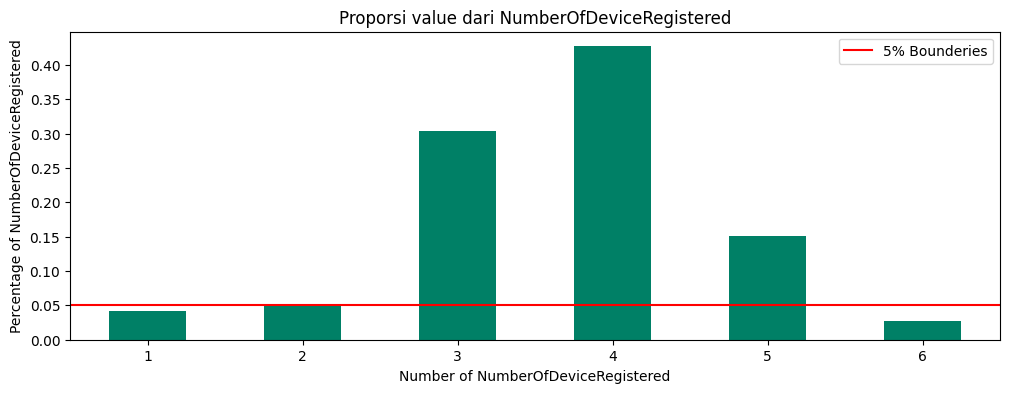

In [28]:
# kolom "NumberOfDeviceRegistered", "NumberOfAddress"
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12,4))

row1 = [ax1]
col1 = ["NumberOfDeviceRegistered"]
title1 = ['Proporsi value dari NumberOfDeviceRegistered']

for i in zip(row1, col1, title1):
    # dfFrame
    temp_df1 = pd.Series(df[i[1]].value_counts() / len(df)).sort_index(ascending=True).plot(kind='bar', label='', ax=i[0], colormap="summer")
    # set title
    i[0].set_title(i[2])
    # horizontal line: boundary yang digunakan adalah 5%, di bawah 5% akan diasumsikan sebagai rare value
    i[0].axhline(y=0.05, color='red', label='5% Bounderies')
    # set x label and its rotation
    i[0].tick_params(axis='x', labelrotation=360)
    i[0].set_xlabel(f"Number of {i[1]}")
    # ylabel
    i[0].set_ylabel(f'Percentage of {i[1]}')
    # legend
    i[0].legend()


# show graph
plt.show()

In [29]:
df[["NumberOfDeviceRegistered"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3264 entries, 0 to 3940
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   NumberOfDeviceRegistered  3264 non-null   int64
dtypes: int64(1)
memory usage: 51.0 KB


__Insight :__
* Imbalance data terjadi pada kolom "***NumberOfDeviceRegistered***" dan "***NumberOfAddress***"
* Pada kolom "***NumberOfDeviceRegistered***" nilai rare value ialah pelanggan yang memiliki 1, 2, dan 6 jumlah perangkat terdaftar. Nilai modus dari kategori ini adalah 4 perangkat terdaftar. Maka kita akan melakukan membagi menjadi 2 kategori yaitu kategori jumlah perangkat terdaftar kurang dari 4, dan lebih besar sama dengan 4
* Pada kolom "***NumberOfAddress***" nilai rare value ialah pelanggan dengan number of address diatas 6. Maka kita akan membuat number of address diatas 6 kedalam kategori ">6"

**Handling rare label** dilakukan pada bagian `preprocessing`

#### **Dealing with The Problem**

Setelah memahami permasalahan data, maka selanjutnya kita akan melakukan preprocessing data dan feature engineering. Yang akan dilakukan adalah:
* Melakukan ***binning*** untuk feature ***`CashbackAmount`*** menjadi tiga kelas (*'Kecil', 'Sedang', 'Besar'*), karena fitur ini memiliki variansi yang tinggi
* Membagi dataset kedalam data df_seen dan df_unseen, yang kemudian dari data df_seen akan dibagi untuk X_train dan X_validasi, serta y_train dan y_validasi 
* Melakukan imputasi pada kolom missing value menggunakan metode ***Iterative Imputer*** untuk kolom "***`Tenure`***", "***`WarehouseToHome`***", "***`DaySinceLastOrder`***"
* Menghilangkan data outlier pada kolom "***Tenure***" dan "***WarehouseToHome***"
* Menghapus data duplikat pada dataset
* Mengganti kategori ***Mobile*** menjadi ***Mobile Phone*** menggunakan pipeline (*Agar ketika terdapat input data baru, model akan mengenali kategori "Mobile" menjadi "Mobile Phone"*)
* Merubah feature "***`MaritalStatus`***" menggunakan One Hot Encoding, karena feature ini tidak memiliki urutan/tidak ordinal, dan juga jumlah kategori datanya hanya sedikit (*Single, Married, Divorced*).
* Merubah feature "***`PreferedOrderCat`***" menggunakan Binnary Encofing,karena feature ini memiliki kategori data yang banyak dan tidak memiliki urutan/tidak ordinal, apabila kita menggunakan One Hot Encoding akan terlalu banyak feature baru yg terbuat, dan jika kita menggunakan Ordinal Encoding hasilnya dapat kurang cocok/kurang baik, karena Ordinal Encoding digunakan ketika kategori memiliki urutan atau susunan tertentu.
* Merubah feature "***`CashbackAmountClass`***" menggunakan Ordinal Encoding, karena kategori pada feature ini memiliki susunan atau urutan tertentu, dari kecil sampai besar

##### > Melakukan ***Binning*** Untuk Feature "***`CashbackAmount`***"

Kita akan lakukan binning untuk feature "***CashbackAmount***" dengan membagi nilai kedalam tiga kategori (*'Kecil', 'Sedang', 'Besar'*)

In [30]:
# Melakukan binning pada kategori cashbackamount

bin_labels= ['Kecil', 'Sedang', 'Besar']

df['CashbackAmountCat']= pd.cut(df['CashbackAmount'], 3, labels=bin_labels)

df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn,CashbackAmountCat
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0,Sedang
1,7.0,25.0,4,Mobile Phone,1,Married,2,0,7.0,129.29,0,Sedang
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0,Sedang
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0,Besar
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0,Besar


In [31]:
# Cek CashbackAmountCat describe
df.groupby('CashbackAmountCat')["CashbackAmount"].describe()

,count,mean,std,min,25%,50%,75%,max
CashbackAmountCat,,,,,,,,
Kecil,10.0,26.100000,26.400547,0.00,3.00,25.00,34.00,81.00
Sedang,2655.0,158.346331,24.386042,110.09,141.81,154.60,175.54,215.94
Besar,599.0,264.275309,32.192623,216.91,233.09,262.58,292.82,324.99


Setelah itu kita akan menghapus feature ***`CashbackAmount`***

In [32]:
# Menghapus feature CashbackAmount

df.drop(columns="CashbackAmount", inplace=True)

##### > Bagi dataset menjadi df_seen dan df_unseen:

Idenya adalah ketika kita melakukan evaluasi terhadap model machine learning, kita ingin mendapatkan model yang dapat menggeneralisir serta akurat. Dalam melakukan generalisasi kita perlu membagi data menjadi 3 bagian, yaitu training set, validation set, dan test set. Dengan penjelasan sebagai berikut:
* Dataset akan kita bagi menjadi df_seen dan df_unseen
* df_seen yang kemudian akan kita bagi lagi menjadi X_train, X_val, y_train, y_val (untuk data training set dan data validasi set)
* df_unseen yang akan menjadi data test set pada model kita nanti

In [33]:
# Melakukan data splitting

# Membagi feature dan target
feature=df.drop(columns=['Churn']).columns
target='Churn'

# Membagi dataset df_seen dan df_unseen dari dataset df
df_seen, df_unseen=train_test_split(df,
                                    stratify=df["Churn"].values, 
                                    test_size=0.2,random_state=0)

# Membagi dataset train dan validation dari df_seen
X_train, X_val, y_train, y_val=train_test_split(df_seen[feature], df_seen[target], 
                                                stratify=df_seen["Churn"].values, 
                                                test_size=0.2, random_state=0)

print(f"df_seen\nJumlah baris: {df_seen.shape[0]} baris\nJumlah kolom: {df_seen.shape[1]} kolom\n")
print(f"df_unseen\nJumlah baris: {df_unseen.shape[0]} baris\nJumlah kolom: {df_unseen.shape[1]} kolom\n")
print("=========================")
print(f"\nX_train\nJumlah baris: {X_train.shape[0]} baris\nJumlah kolom: {X_train.shape[1]} kolom\n")
print(f"X_val\nJumlah baris: {X_val.shape[0]} baris\nJumlah kolom: {X_val.shape[1]} kolom")

df_seen
Jumlah baris: 2611 baris
Jumlah kolom: 11 kolom

df_unseen
Jumlah baris: 653 baris
Jumlah kolom: 11 kolom


X_train
Jumlah baris: 2088 baris
Jumlah kolom: 10 kolom

X_val
Jumlah baris: 523 baris
Jumlah kolom: 10 kolom


Maka kita sudah memiliki data untuk training, validasi dan tes

##### > Melakukan Iterative Imputer

Seperti yang sudah dianalisis pada bagian sebelumnya bahwa kita akan melakukan imputasi kepada kolom yang memiliki missing value (***"Tenure", "WarehouseToHome", "DaySinceLastOrder"***). Kita akan lakukan imputasi untuk semua dataset yang kita miliki (*`df_seen, df_unseen, X_train, X_val`*), sebagai berikut:

In [34]:
# Melakukan imputasi

# Fungsi untuk melakukan imputasi
def imputasi(df_seen, df_unseen, X_train, X_val, feature):
    imputerCont = IterativeImputer(max_iter=10, random_state=0)
    imputerCont.fit(df_seen[feature])
    df_seen[feature] = imputerCont.transform(df_seen[feature])
    df_unseen[feature] = imputerCont.transform(df_unseen[feature])
    X_train[feature] = imputerCont.transform(X_train[feature])
    X_val[feature] = imputerCont.transform(X_val[feature])
    return df_seen, df_unseen, X_train, X_val

colsMissing = ["Tenure", "WarehouseToHome", "DaySinceLastOrder"]

df_seen, df_unseen, X_train, X_val = imputasi(df_seen, df_unseen, X_train, X_val, colsMissing) #<- Fungsi yang dibuat pada pengerjaan model ini

In [35]:
# Cek jumlah missing value untuk df_seen dan df_unseen

print(df_seen.isna().sum(), df_unseen.isna().sum())

Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
Churn                       0
CashbackAmountCat           0
dtype: int64 Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
Churn                       0
CashbackAmountCat           0
dtype: int64


In [36]:
# Cek jumlah missing value untuk X_train dan X_val

print(X_train.isna().sum(), X_val.isna().sum())

Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmountCat           0
dtype: int64 Tenure                      0
WarehouseToHome             0
NumberOfDeviceRegistered    0
PreferedOrderCat            0
SatisfactionScore           0
MaritalStatus               0
NumberOfAddress             0
Complain                    0
DaySinceLastOrder           0
CashbackAmountCat           0
dtype: int64


Dari proses yang sudah kita lakukan diatas, maka sekarang kita sudah tidak memiliki nilai missing value

##### > Melakukan Encoding dan Scalling

In [37]:
# Ordinal mapping kolom cashbackamountclass
ordinal_mapping_cashbackamountclass = [
    {'col':'CashbackAmountCat',
    'mapping':{
        'Kecil' : 0, 
        'Sedang': 1, 
        'Besar' : 2,
    }}
]

In [38]:
# Transformer
from sklearn.preprocessing import FunctionTransformer

# def a(x):
#     # return np.where(x=='Mobile', 'Mobile Phone', x)

transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['MaritalStatus']),
    ('ordinalCashback', ce.OrdinalEncoder(mapping= ordinal_mapping_cashbackamountclass), ['CashbackAmountCat']),
    ('binary', ce.BinaryEncoder(), ['PreferedOrderCat'])
], remainder='passthrough') 

In [39]:
# Melihat preview hasil encoding
testing = pd.DataFrame(transformer.fit_transform(df_seen), columns=transformer.get_feature_names_out())
testing

,onehot__MaritalStatus_Married,onehot__MaritalStatus_Single,ordinalCashback__CashbackAmountCat,binary__PreferedOrderCat_0,binary__PreferedOrderCat_1,binary__PreferedOrderCat_2,remainder__Tenure,remainder__WarehouseToHome,remainder__NumberOfDeviceRegistered,remainder__SatisfactionScore,remainder__NumberOfAddress,remainder__Complain,remainder__DaySinceLastOrder,remainder__Churn
0,0.0,0.0,1.0,0.0,0.0,1.0,13.0,8.0,4.0,3.0,7.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,1.0,11.0,5.0,2.0,3.0,1.0,4.0,0.0
2,1.0,0.0,1.0,0.0,0.0,1.0,13.0,8.0,1.0,4.0,2.0,0.0,7.0,0.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,15.0,5.0,3.0,3.0,1.0,3.0,1.0
4,0.0,1.0,1.0,0.0,0.0,1.0,1.0,11.0,5.0,1.0,3.0,1.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2606,0.0,1.0,1.0,0.0,0.0,1.0,1.0,22.0,1.0,5.0,1.0,0.0,7.0,0.0
2607,0.0,1.0,1.0,0.0,0.0,1.0,17.0,6.0,4.0,3.0,5.0,0.0,2.0,0.0
2608,0.0,1.0,1.0,0.0,1.0,0.0,7.0,15.0,5.0,1.0,2.0,0.0,3.0,0.0
2609,0.0,1.0,1.0,0.0,0.0,1.0,12.0,34.0,4.0,5.0,4.0,0.0,3.0,1.0


##### **Setelah dilakukan *`data understanding`* dan *`data preprocesing`* pada langkah diatas, maka kita **`menganggap`** data yang kita miliki sudah bersih dan siap untuk dilakukan modeling**

### **`Modeling`**

#### **Model Experiment**

Metode klasifikasi yang akan kita coba sebagai penentuan model terbaik untuk dataset ini antara lain *Logistic Regression*, *KNearest Neighbour Classifier*, *Decision Tree Classifier*, *Random Forest Classifier*, *Ada Boost Classifier*, dan *Gradient Boosting Classifier*.

In [40]:
# Model yang digunakan

logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0)
gbc = GradientBoostingClassifier(random_state=0)
catboost = CatBoostClassifier(random_state=0, verbose=False)
# catboost.set_probability_threshold(0.20)

In [41]:
# hyperparameter default

# Pilihan model yang akan digunakan
models = [logreg,knn,dt,rf,ada,gbc,catboost]

# Precision
scorePrec=[]
rataPrec=[]
stdPrec=[]

# Recall
scoreRecall=[]
rataRecall=[]
stdRecall=[]

# PR_AUC
scorePR_AUC=[]
rataPR_AUC=[]
stdPR_AUC=[]


for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('models',i)])

    # Matriks Precision
    modelCVPrec=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring="precision")
    scorePrec.append(modelCVPrec)
    rataPrec.append(modelCVPrec.mean())
    stdPrec.append(modelCVPrec.std())

    # Matriks Recall
    modelCVRec=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring="recall")
    scoreRecall.append(modelCVRec)
    rataRecall.append(modelCVRec.mean())
    stdRecall.append(modelCVRec.std())

    # Matriks PR_AUC
    modelCVPR_AUC=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring="average_precision")
    scorePR_AUC.append(modelCVPR_AUC)
    rataPR_AUC.append(modelCVPR_AUC.mean())
    stdPR_AUC.append(modelCVPR_AUC.std())

pd.DataFrame({'Models':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Ada', 'Gradient Boosting', 'CatBoosting'],
              'Mean precision':rataPrec,
              'Mean recall':rataRecall,
              'Mean PR_AUC':rataPR_AUC,
              'Std PR_AUC':stdPR_AUC}).set_index('Models').sort_values(by='Mean PR_AUC',ascending=False)

,Mean precision,Mean recall,Mean PR_AUC,Std PR_AUC
Models,,,,
CatBoosting,0.793423,0.571952,0.773035,0.009391
Random Forest,0.788680,0.525107,0.750313,0.036708
Gradient Boosting,0.755767,0.542498,0.727451,0.027010
Ada,0.693262,0.522123,0.667848,0.034916
Logistic Regression,0.693479,0.428176,0.631186,0.036482
KNN,0.623390,0.416539,0.518319,0.042561
Decision Tree,0.629422,0.613001,0.452146,0.047361


Dari hasil *hyperparameter default* diatas dapat kita dapat lihat bahwa model yang memiliki nilai tertinggi pada Precision, Recall, dan PR_AUC adalah ***`CatBoosting`***, dan nilai std nya juga kecil. Maka model ***`CatBoosting`*** akan menjadi pilihan model

Selanjutnya kita akan coba implementasi model terpilih kedalam data test sebagai berikut:

In [42]:
# Optimasi model benchmark

models = [logreg,knn,dt,rf,ada,gbc,catboost]
score_PR_AUC = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model_catboost',i)])
    X_train,X_val
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_val),X_val)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Ada', 'Gradient Boosting', 'CatBoosting']):
    estimator,y_pred,X_val = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(X_val)[:,1]

    # Score PR_AUC
    score_PR_AUC.append(average_precision_score(y_val,y_predict_proba))
    print(j,'\n', classification_report(y_val,y_pred))
    
pd.DataFrame({'Models':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Ada', 'Gradient Boosting', 'CatBoosting'],
            'PR_AUC score':score_PR_AUC}).set_index('Models').sort_values(by='PR_AUC score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       438
           1       0.70      0.39      0.50        85

    accuracy                           0.87       523
   macro avg       0.80      0.68      0.71       523
weighted avg       0.86      0.87      0.86       523

KNN 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93       438
           1       0.66      0.44      0.52        85

    accuracy                           0.87       523
   macro avg       0.78      0.70      0.73       523
weighted avg       0.86      0.87      0.86       523

Decision Tree 
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       438
           1       0.61      0.64      0.62        85

    accuracy                           0.88       523
   macro avg       0.77      0.78      0.77       523
weighted avg       0.88      0

,PR_AUC score
Models,
CatBoosting,0.788726
Random Forest,0.777472
Gradient Boosting,0.734811
Ada,0.706629
Logistic Regression,0.649111
KNN,0.514625
Decision Tree,0.449113


Dari data diatas dapat dilihat kembali untuk model ***`Cat Boosting`*** merupakan model dengan **PR_AUC** tertinggi yaitu 0.78. Sehingga step selanjutnya kita coba meningkatkan performa dengan melakukan *tuning hyperparameter* pada ***Cat Boosting*** dan membandingkan performanya kembali 

#### **Hyperparameter Tunning**

***Hyperparameter tuning*** penting untuk mengontrol perilaku keseluruhan model machine learning. Akan dilakukan hyperparameter tuning pada model `Cat Boosting`, dengan harapan model lebih optimal. Ada beberapa parameter yang akan dituning antara lain:
* `learning_rate` = Mengontrol tingkat pembelajaran model
* `iterations` = Menentukan jumlah pohon (estimator) yang akan dibangun
* `depth` = Menentukan kedalaman maksimum dari setiap pohon
* `l2_leaf_reg` = Mengendalikan kekuatan regularisasi L2 untuk mengurangi overfitting

In [61]:
# CatBoost Hyperparameter Tuning
catboost = CatBoostClassifier(random_state=0, verbose=False)

# Settings pipeline
Pipe_catboost = Pipeline([('preprocess', transformer), ('model_catboost', catboost)]) 
skfold=StratifiedKFold(n_splits=10, random_state=0, shuffle=True) #RepeatedStratifiedKFold

# Searching for the best parameters using Grid Search.
hyperparam_catboost = {
    'model_catboost__learning_rate': [0.01, 0.5, 1],
    'model_catboost__iterations': [400, 700],
    'model_catboost__depth': [5, 10],
    'model_catboost__l2_leaf_reg': [1, 5]
}

catboost_grid = GridSearchCV(estimator = Pipe_catboost,
                      param_grid = hyperparam_catboost, 
                      cv = skfold, 
                      scoring = 'average_precision',
                      error_score='raise',
                      verbose = False
                      )

catboost_grid.fit(X_train,y_train)

# Cat Boost
print('Cat Boost Hyperparameter')
print(catboost_grid.best_score_)
print(catboost_grid.best_params_)

Cat Boost Hyperparameter
0.8251982159473122
{'model_catboost__depth': 10, 'model_catboost__iterations': 700, 'model_catboost__l2_leaf_reg': 1, 'model_catboost__learning_rate': 0.01}


In [62]:
# Cat Boost
print('Cat Boost Hyperparameter')
print(catboost_grid.best_score_)
print(catboost_grid.best_params_)

Cat Boost Hyperparameter
0.8251982159473122
{'model_catboost__depth': 10, 'model_catboost__iterations': 700, 'model_catboost__l2_leaf_reg': 1, 'model_catboost__learning_rate': 0.01}


*Hyperparameter tuning* dilakukan dengan membandingkan nilai default dengan nilai yang nilainya ditune secara berulang, selain itu dibantu dengan iterasi grid search. 
Dari pengamatan yang dilakukan dengan beberapa kali percobaan tuning, didapatkan parameter terbaik dengan data berikut:
* **`Nilai terbaik`** yang didapatkan 0.82
* **`learning_rate`** terbaik 0.01
* **`iterations`** terbaik 445
* **`depth`** seperti default yaitu 10
* **`l2_leaf_reg`** terbaik 1

Selanjutnya kita akan melakukan cross validate dan membandingkan hasil sebelum tuned (***default***), dengan ***hasil tuned***. Validasi silang adalah teknik evaluasi yang berguna untuk mengukur kinerja model secara lebih akurat daripada hanya membagi dataset menjadi satu set pelatihan dan satu set pengujian.

In [73]:
# Bagi data seen kedalam X_trainSeen, y_trainSeen

X_trainSeen = df_seen.drop(columns='Churn')
y_trainSeen = df_seen['Churn']

In [64]:
# cross validate hasil sebelum tuned (default)

cv_results = cross_validate(
    estimator,
    X_trainSeen,
    y_trainSeen,
    cv=3,
    scoring=['average_precision'],
    return_train_score=True,
    verbose=False
    )

cv_results

{'fit_time': array([10.24557018,  4.88179183,  4.1889739 ]),
 'score_time': array([1.09066033, 0.02720785, 0.02194238]),
 'test_average_precision': array([0.80676832, 0.77283603, 0.73596883]),
 'train_average_precision': array([0.97934874, 0.98648874, 0.98007835])}

In [74]:
# Bagi data seen kedalam X_trainSeen, y_trainSeen

X_trainSeen = df_seen.drop(columns='Churn')
y_trainSeen = df_seen['Churn']

In [75]:
# cross validate hasil sesudah tuned

cv_results = cross_validate(
    catboost_grid,
    X_trainSeen,
    y_trainSeen,
    cv=3,
    scoring=['average_precision'],
    return_train_score=True,
    verbose=False
    )

cv_results

Berdasarkan hasil cross validasi diatas, kita dapat menyimpulkan bahwa model sebelum tuned lebih baik. Sehingga kita akan menggunakan model untuk kedepannya

#### **Final Model**

Pertama kita akan bagi **`df_unseen`** menjadi **X_test** dan **y_test**

In [ ]:
X_test = df_unseen.drop(columns='Churn')
y_test = df_unseen['Churn']

Setelah itu kita akan membandingkan model ***Default*** dan model ***Tuned***

In [66]:
# Model CatBoosting Default

catboost = CatBoostClassifier(random_state=0, verbose=False)
estimator=Pipeline([
    ('preprocess',transformer),
    ('model_catboost',catboost)
])
estimator.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['MaritalStatus']),
                                                 ('ordinalCashback',
                                                  OrdinalEncoder(mapping=[{'col': 'CashbackAmountCat',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Kecil     0
Sedang    1
Besar     2
dtype: int64}]),
                                                  ['CashbackAmountCat']),
                                                 ('binary', BinaryEncoder(),
                                                  ['PreferedOrderCat'])])),
                ('model_catboost',
                 <catboost.core.CatBoostClassifier object at 0x00000222C1D3DC70>)])

In [67]:
# Model CatBoosting Tuned

best_model = catboost_grid.best_estimator_ #<- Sudah dilakukan fitting pada proses sebelumnya

In [ ]:
# Melihat perbandingan model dengan default dan hyperparameter tuning

# Default
y_pred_default = estimator.predict(X_test)
y_pred_proba_default = estimator.predict_proba(X_test)

# Tuned
y_pred_tuned = best_model.predict(X_test)
y_pred_proba_tuned = best_model.predict_proba(X_test)

pr_auc_default = average_precision_score(y_test, y_pred_proba_default[:,1])
pr_auc_tuned = average_precision_score(y_test, y_pred_proba_tuned[:,1])

print('PR_AUC Score Default CatBoosting : ', pr_auc_default)
print('PR_AUC Score Tuned CatBoosting : ', pr_auc_tuned)

Pada dua data diatas terdapat beberapa hal yang dapat diketahui, antara lain:
* Dari melakukan *hyperparameter tuning*, dapat dilihat selisih test `CatBoosting` default dan tuned tidak berbeda jauh yaitu selisih **PR_AUC** 0.02. Nilai **PR_AUC** pada parameter yang telah dituning adalah 0.95. 
* Nilai *hyperparameter tuning* sudah dibandingkan dengan parameter default, dan didapatkan nilai yang cukup baik. Analisa yang dapat ditingkatkan lebih lanjut adalah **pemilihan parameter dengan nilai yang ditentukan sebagai referensi serta menguji hyperparameter lain**.
* Sehingga model yang akan digunakan adalah model yang menggunakan *hyperparameter tuning*, dengan metrik yang didapatkan pada kelas positif yaitu recall  0.70 dan precision 0.74, dengan f1 score 0.72. Pada kelas negatif didapat recall 0.95 dan precision 0.94, dengan f1 score 0.95. Analisa selanjutnya yang dapat ditingkatkan adalah **meningkatkan nilai recallnya pada kelas positif dengan melakukan tuning threshold pada **PR_AUC****. 

In [ ]:
# Model CatBoosting Tuned

best_model = catboost_grid.best_estimator_
churn_model = best_model.fit(X_train, y_train)

In [ ]:
report = classification_report(y_test, y_pred_tuned)
print(report)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tuned).ravel()
print(f"TN: {tn} | FP: {fn}\nFN: {fn}  | TP: {tp}")

#### **Model Intepretation**

Model interpretasi digunakan untuk memahami dan menjelaskan cara kerja model prediksi atau klasifikasi dalam konteks yang lebih mudah dimengerti oleh manusia

Pertama kita akan bagi **`df_unseen`** menjadi **X_test** dan ***y_test***

In [68]:
X_test = df_unseen.drop(columns='Churn')
y_test = df_unseen['Churn']

In [69]:
y_pred_catboost = best_model.predict(X_test)
y_pred_proba_catboost =  best_model.predict_proba(X_test)

##### **Partial Dependence**

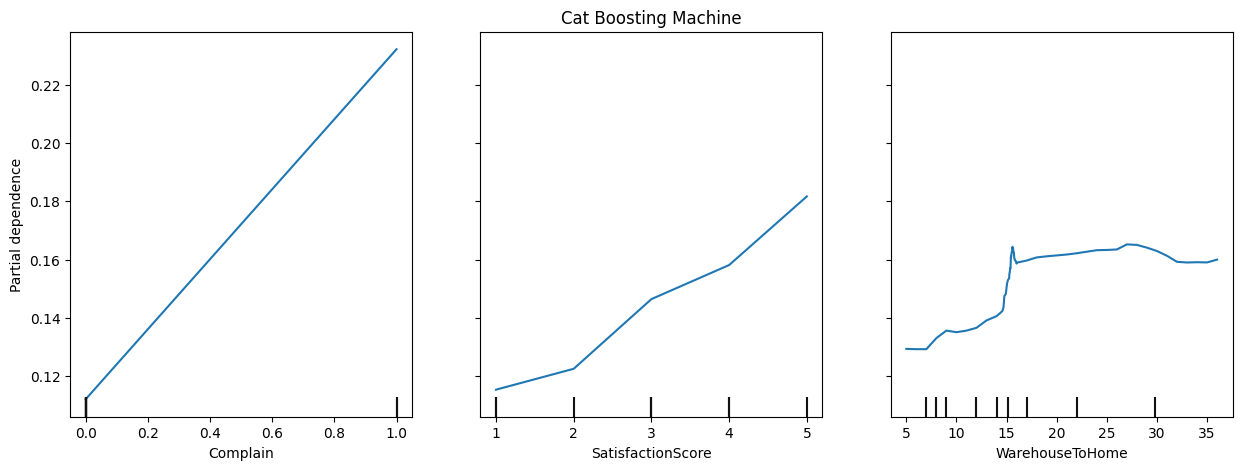

In [70]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(15, 5))
ax.set_title("Cat Boosting Machine")
tree_disp = PartialDependenceDisplay.from_estimator(best_model, X_train, ["Complain", "SatisfactionScore", "WarehouseToHome"], ax=ax)

##### **Feature Importance**

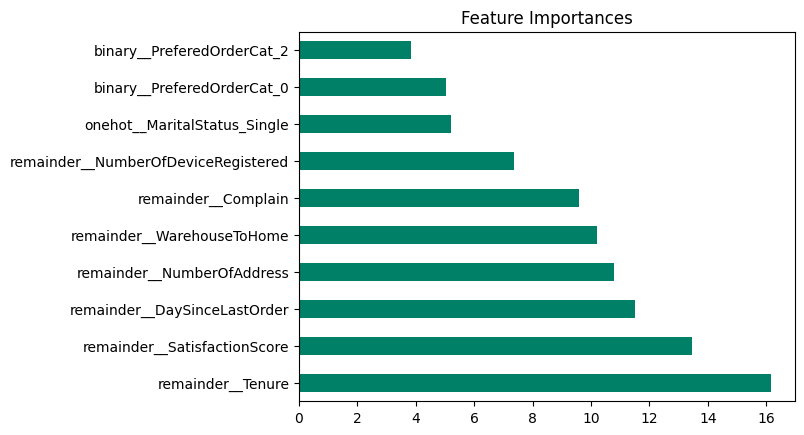

In [71]:
coef1 = pd.Series(best_model["model_catboost"].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances', colormap="summer")
plt.show()

Model limitassi dari model untuk memprediksi data seen (FP FN) analisis karakteristik datanya -> yang dijadikan limitasi model (model tidak akan berjalan akurat kalau kondisi diluar data)

* Dikondisi mana model memberikan hasil yang dapat dipercaya/bekerja baik dan bekerja buruk
* .....
* .....

### **`Conclusion`**

In [72]:
report = classification_report(y_test, y_pred_tuned)
print(report)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tuned).ravel()
print(f"TN: {tn} | FP: {fn}\nFN: {fn}  | TP: {tp}")

NameError: name 'y_pred_tuned' is not defined

**`BELUM FIX`**

Beberapa hal yang dapat disimpulkan yaitu:

Berdasarkan hasil diatas dapat disimpulkan bahwa dengan prediksi menggunakan model CatBoosting yang sudah dibuat, model dapat mengetahui 82% pelanggan yang ***churn*** dan 94% pelanggan yang ***tidak churn*** berdasarkan ***precision***. Selain itu model memiliki kemungkinan prediksi benar untuk pelanggan yang akan churn sebesar 74%. Maka masih ada pelanggan yang churn dan diprediksi sebagai tidak churn sebesar 4%. 
  
Bila seandainya biaya mempertahankan pelanggan 10$ dan biaya mendapatkan pelanggan baru 40$, dan terdapat 3264 pelanggan dimana pelanggan yang churn 533 orang dan yang tidak churn 2731 orang, maka kurang lebih perhitungannya adalah sebagai berikut:  
  
*Tanpa Model* (Semua pelanggan diberikan penawaran):
- Total Biaya => 3264 * 10 = 32.640 USD
- Total pelanggan churn yang ditemukan => 533 orang
- Total pelanggan churn yang tidak ditemukan => 0 orang
- Total pelanggan tidak churn yang ditemukan => 2731 orang
- Total pelanggan tidak churn yang tidak ditemukan => 0 orang
- Biaya yang terbuang => 2731 x 10 = 27.310 USD

*Dengan Model* (Penawaran diberikan sesuai prediksi):
- Total Biaya => (533 x 0.70) x 10= 3.731 USD
- Total pelanggan churn yang ditemukan => (533x0.7)= 374 orang
- Total pelanggan churn yang tidak ditemukan => 159 + (2731 x 0.04) = 268 orang
- Total pelanggan tidak churn yang ditemukan => (2731 x 0.95)= 2595 orang
- Total pelanggan tidak churn yang tidak ditemukan => 136 orang
- Biaya yang terbuang => (136x 10USD) + (268 X 40USD) = 1.360 + 10.720 = 12.080 USD
- Jumlah penghematan => 27.310 - 12.080 = 15.230USD 

Dengan adanya bantuan model, perusahan e-commerce dapat menghemat biaya yang cukup besar dengan melakukan pemasaran yang lebih tepat sasaran.

Selain itu, berdasarkan analisa faktor yang berpengaruh dengan customer churn adalah complain dan masa tenure pelanggan. Hal tersebut harus diperhatikan, apabila pelanggan melakukan complain dan semakin kecil masa tenure pelanggan, ada potensi customer churn. 

### **`Recommendations`**

Hal yang dapat dilakukan untuk mengembangkan model agar lebih baik lagi, seperti:

* ....
* ....
* ....

**`BELUM FIX`**

Adapun beberapa rekomendasi yang dapat diberikan terkait sisi bisnis dan model:  
  
* Business:
    - Memberikan penawaran pada pelanggan dengan masa tenure 0-2 bulan yang berpotensi churn, berupa promo, cashback, atau subscription sehingga pelanggan lebih tertarik untuk menggunakan platform e-commerce terus-menerus
    - Memperhatikan complain yang diberikan pelanggan, baik itu dari segi kemudahan penggunaan platform e-commerce, memperbanyak variasi produk dengan mencari mitra, mengoptimalkan live chat antar pelanggan-pembeli dan pelanggan-support centre, memonitor dan memberi pelatihan kepada marketplace yang terdaftar sehingga memberikan service dan produk yang memuaskan. 
    - Memberikan penawaran pemotongan ongkos kirim pada potensi customer churn yang memiliki jarak antar warehouse dan rumah yang jauh
    - Menggunakan model machine learning yang telah dibuat sebagai solusi untuk menentukan strategi pemasaran yang tepat sasaran     
    
     
* Model:
    - Saat penarikan data, data diharapkan memiliki kolom customer ID untuk memastikan tidak adanya data yang duplikat, serta memastikan data yang didapat tidak ada missing value
    - Adanya kolom dengan fitur lain yang berhubungan langsung dengan servis yang perusahaan e-commerce berikan dan transaksi pelanggan, seperti berapa lama pengiriman produk, ketepatan waktu pengiriman, kolom customer service helpful atau tidak, dan sebagainya
    - Model dapat ditingkatkan dengan melakukan tuning hyperparameter dengan nilai yang sudah didapat sebagai referensi, atau menambahkan parameter lain
    - Meningkatkan nilai recall dengan tuning threshold ROC-AUC
    - Memilah fitur sesuai dengan feature importances dan melakukan trial kombinasi fitur yang berpengaruh untuk mengurangi kompleksitas model